# Assignment 1: Labor Supply and Children

## 0: Setup and solve model

In [90]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from DynLaborFertModel import *

# save and load models
save = False
load = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Estimate $\beta_1$

In [91]:
model_est = DynLaborFertModelClass(name='estimation', load=True) #coarser grid for estimation 
kwargs = {'method':'brentq', 'bracket':(0.04, 0.06), 'maxiter': 10, 'xtol':0.001}

if model_est.sol.solved == False:
    model_est.estimate(**kwargs)

if save:
    model_est.save()

beta_1 = model_est.par.beta_1

#### 1.1 Solve and simulate baseline model with estimated $\beta_1$

In [92]:
model = get_model_solution(name='baseline', load=load, save=save, par={'beta_1':beta_1})

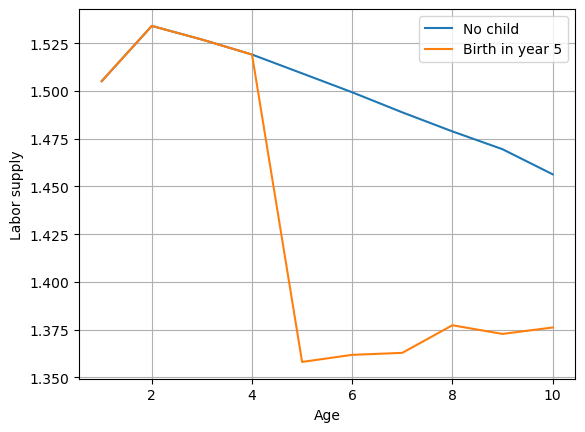

In [93]:
I = model.sim.n[:,-1] == 0
birthyear = np.argmax(np.diff(model.sim.n), axis=1) + 1
birthyear[I] = 0
year = 4

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(1,model.par.simT+1), model.sim.h[I].mean(axis=0), label='No child', c=blue)
ax.plot(range(1,model.par.simT+1), model.sim.h[birthyear == year].mean(axis=0), label=f'Birth in year {year+1}', c=orange)

ax.set_xlabel('Age')
ax.set_ylabel('Labor supply')

ax.grid()
ax.legend()

fig.savefig('fig/labor_baseline.pdf')

In [94]:
# Produce Event-plot
# birth
# compute moment
birth = np.zeros(model.sim.n.shape,dtype=np.int_)
birth[:,1:] = (model.sim.n[:,1:] - model.sim.n[:,:-1]) > 0

# time since birth
periods = np.tile([t for t in range(model.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model.par.simT,1)))
time_since_birth = periods - time_of_birth

# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

event_hours_rel = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_rel[t] = np.mean(model.sim.h[time_since_birth==time])/np.mean(model.sim.h[time_since_birth==-1])-1

In [95]:
birth = np.zeros(model.sim.n.shape,dtype=np.int_)
birth[:,1:] = (model.sim.n[:,1:] - model.sim.n[:,:-1]) > 0

# time since birth
periods = np.tile([t for t in range(model.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model.par.simT,1)))
time_since_birth = periods - time_of_birth

# compute drop in hours in birth year
drop_y0 = np.mean(model.sim.h[time_since_birth==0])/np.mean(model.sim.h[time_since_birth == -1]) -1

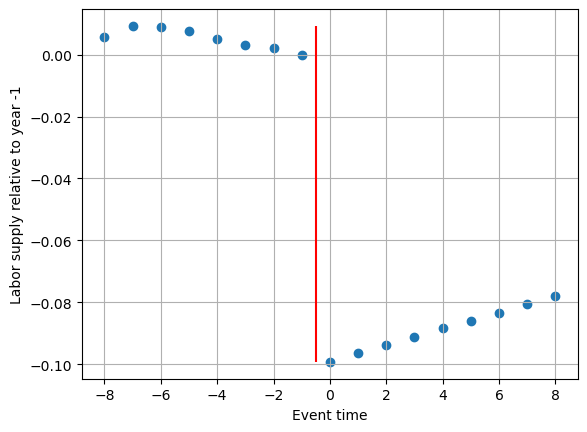

In [96]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(event_grid, event_hours_rel);
ax.set_xlabel('Event time')
ax.set_ylabel('Labor supply relative to year -1')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel),ymax=np.nanmax(event_hours_rel),color='red')
ax.grid()

fig.savefig('fig/event.pdf')

## 2. Marshall elasticity

In [97]:
model_tax = get_model_solution('tax', load=load, save=save, par={'beta_1':beta_1, 'tau':model.par.tau*1.01})

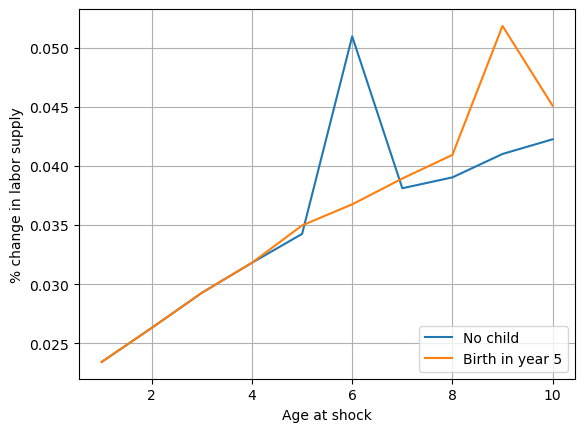

In [98]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

year = 4

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

ax.plot(range(1, model.par.simT+1), marshall_age_birth(model, model_tax, 0), label='No child', c=blue)
ax.plot(range(1, model.par.simT+1), marshall_age_birth(model, model_tax, year), label=f'Birth in year {year+1}',c=orange)


ax.legend(loc='lower right')
ax.set_ylabel('% change in labor supply')
ax.set_xlabel('Age at shock')
ax.grid()

fig.savefig('fig/baseline_marshall.pdf') 

## 3.  Introduce spouse

In [99]:
model_spouse = get_model_solution(name='spouse', load=load, save=save, par={'y0':0.1,'y1':0.01, 'beta_1':beta_1})

In [100]:
model_spouse_tax = get_model_solution(name='spouse_tax', load=load, save=save, par={'y0':0.1,'y1':0.01, 'beta_1':beta_1, 'tau':model_spouse.par.tau*1.01})

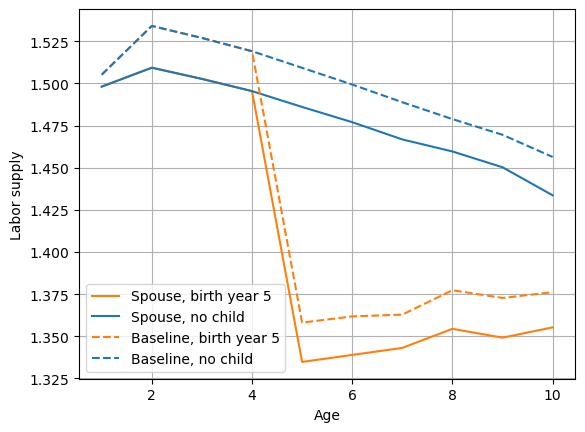

In [101]:
I = model.sim.n[:,-1] == 0
birthyear = np.argmax(np.diff(model.sim.n), axis=1) + 1
birthyear[I] = 0
year = 4

I_sp = model_spouse.sim.n[:,-1] == 0
birthyear_spouse = np.argmax(np.diff(model_spouse.sim.n), axis=1) + 1
birthyear_spouse[I_sp] = 0

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(range(1,model.par.simT+1),model_spouse.sim.h[birthyear_spouse == year].mean(axis=0),
        label=f'Spouse, birth year {year+1}',
        c=orange)

ax.plot(range(1,model.par.simT+1),model_spouse.sim.h[I_sp].mean(axis=0), 
        label='Spouse, no child', 
        c=blue)

ax.plot(range(1,model.par.simT+1),model.sim.h[birthyear == year].mean(axis=0), 
        label=f'Baseline, birth year {year+1}',
        c=orange,
        linestyle='--')
ax.plot(range(1,model.par.simT+1),model.sim.h[I].mean(axis=0), 
        label='Baseline, no child', 
        c=blue,
        linestyle='--')


ax.set_xlabel('Age')
ax.set_ylabel('Labor supply')
ax.grid()
ax.legend(loc='lower left')

fig.savefig('fig/spouse_labor.pdf')

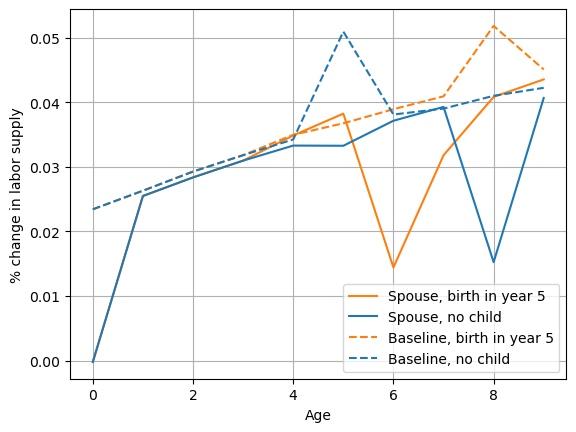

In [102]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

year=4

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

ax.plot(marshall_age_birth(model_spouse, model_spouse_tax, year), 
        label=f'Spouse, birth in year {year+1}',
        c=orange)
ax.plot(marshall_age_birth(model_spouse, model_spouse_tax, 0), 
        label=f'Spouse, no child',
        c=blue)
ax.plot(marshall_age_birth(model, model_tax, year), 
        label=f'Baseline, birth in year {year+1}',
        c=orange,
        linestyle='--')
ax.plot(marshall_age_birth(model, model_tax, 0), 
        label=f'Baseline, no child',
        c=blue,
        linestyle='--')

    
ax.legend(loc='lower right')
ax.grid()
ax.set_xlabel('Age')
ax.set_ylabel('% change in labor supply')

fig.savefig('fig/spouse_marshall.pdf')

## 4. Childcare cost

In [103]:
model_childcare = get_model_solution(name='childcare_cost', load=load, save=save, par={'beta_1':beta_1, 'c_cost':0.05})

In [104]:
model_childcare_tax = get_model_solution(name='childcare_cost_tax', load=load, save=save,  par={'beta_1':beta_1, 'c_cost':0.05, 'tau':model_childcare.par.tau*1.01})

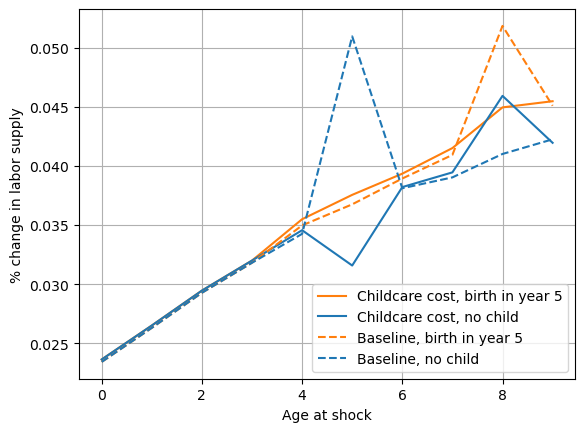

In [105]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

year = 4

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

ax.plot(marshall_age_birth(model_childcare, model_childcare_tax, year),
        label=f'Childcare cost, birth in year {year+1}',
        c=orange)
ax.plot(marshall_age_birth(model_childcare, model_childcare_tax, 0),
        label='Childcare cost, no child',
        c=blue)

ax.plot(marshall_age_birth(model, model_tax, year),
        label=f'Baseline, birth in year {year+1}',
        c=orange,
        linestyle='--')
ax.plot(marshall_age_birth(model, model_tax, 0),
        label='Baseline, no child',
        c=blue,
        linestyle='--')

ax.legend(loc='lower right')
ax.set_xlabel('Age at shock')
ax.set_ylabel('% change in labor supply')
ax.grid()

fig.savefig('fig/childcare_marshall.pdf')

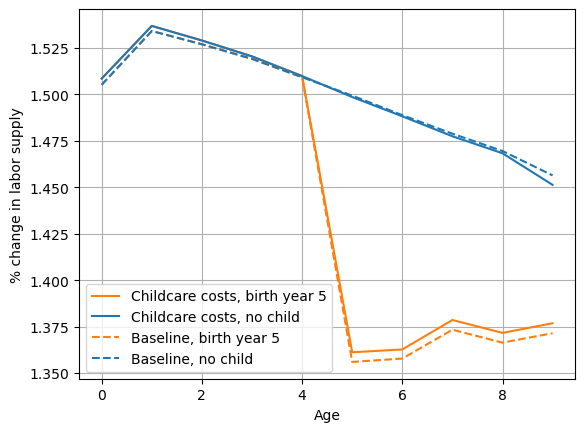

In [106]:
I = model.sim.n[:,-1] == 0
birthyear = np.argmax(np.diff(model.sim.n), axis=1)
year = 4

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(model_childcare.sim.h[birthyear == year].mean(axis=0), 
        label=f'Childcare costs, birth year {year+1}',
        c=orange)
ax.plot(model_childcare.sim.h[I].mean(axis=0),
         label='Childcare costs, no child',
         c=blue)

ax.plot(model.sim.h[birthyear == year].mean(axis=0), 
        label=f'Baseline, birth year {year+1}',
        c=orange,
        linestyle='--')
ax.plot(model.sim.h[I].mean(axis=0), 
        label='Baseline, no child',
        c=blue,
        linestyle='--')

ax.legend(loc='lower left')
ax.grid()
ax.set_xlabel('Age')
ax.set_ylabel('% change in labor supply')

fig.savefig('fig/childcare_labor.pdf')

## 6. Stochastic spouse

In [107]:
model_stspouse = get_model_solution(name='st_spouse', load=load, save=save, 
                                    par={'beta_1':beta_1, 'p_spouse':0.8, 'y0': 0.1, 'y1':0.01})

In [108]:
model_stspouse_tax = get_model_solution(name='st_spouse_tax', load=load, save=save, 
                                        par={'beta_1':beta_1, 'p_spouse':0.8, 'y0': 0.1, 'y1':0.01, 'tau':model_stspouse.par.tau*1.01})

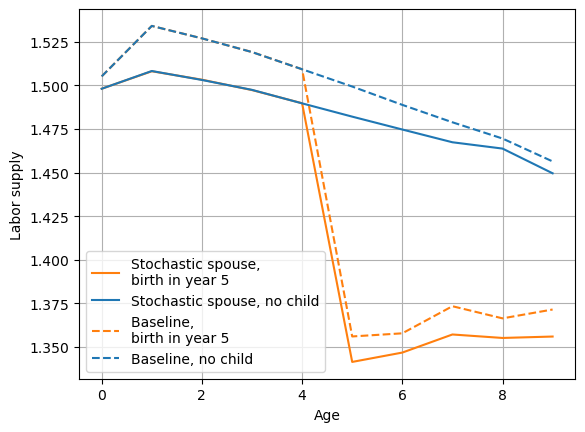

In [109]:
I = model.sim.n[:,-1] == 0
birthyear = np.argmax(np.diff(model.sim.n), axis=1)

year = 4

I_stoch = model_stspouse.sim.n[:,-1] == 0
birthyear_stoch = np.argmax(np.diff(model_stspouse.sim.n), axis=1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

blue = mcolors.TABLEAU_COLORS['tab:blue']
orange = mcolors.TABLEAU_COLORS['tab:orange']

ax.plot(model_stspouse.sim.h[birthyear_stoch == year].mean(axis=0), 
        label=f'Stochastic spouse, \nbirth in year {year+1}',
        c=orange)
ax.plot(model_stspouse.sim.h[I_stoch].mean(axis=0), 
        label='Stochastic spouse, no child',
        c=blue)

ax.plot(model.sim.h[birthyear == year].mean(axis=0), 
        label=f'Baseline, \nbirth in year {year+1}',
        c=orange,
        linestyle='--')
ax.plot(model.sim.h[I].mean(axis=0), 
        label='Baseline, no child',
        c=blue,
        linestyle='--')

ax.legend(loc='lower left')
ax.set_xlabel('Age')
ax.set_ylabel('Labor supply')
ax.grid()
ax.legend(loc='lower left')

fig.savefig('fig/stspouse_labor.pdf')


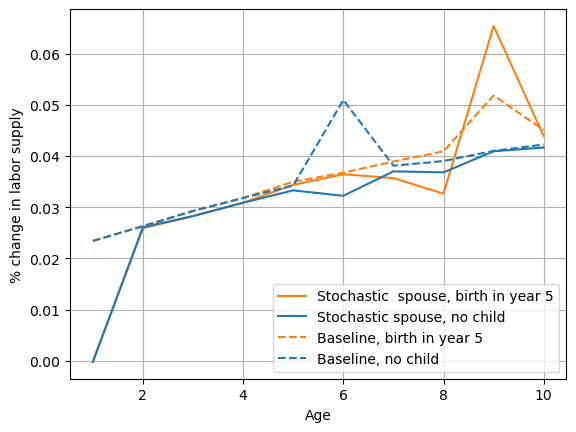

In [110]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

year = 4

I_stoch = model_stspouse.sim.n[:,-1] == 0
birthyear_stoch = np.argmax(np.diff(model_stspouse.sim.n), axis=1)

ax.plot(range(1,model_stspouse.par.simT+1), marshall_age_birth(model_stspouse, model_stspouse_tax, year),
        label=f'Stochastic  spouse, birth in year {year+1}',
        c=orange)
ax.plot(range(1, model_stspouse.par.simT+1), marshall_age_birth(model_stspouse, model_stspouse_tax, 0),
        label='Stochastic spouse, no child',
        c=blue)

ax.plot(range(1, model.par.simT+1), marshall_age_birth(model,model_tax,year),
        label=f'Baseline, birth in year {year+1}',
        c=orange,
        linestyle='--')
ax.plot(range(1, model.par.simT+1), marshall_age_birth(model, model_tax, 0),
        label='Baseline, no child',
        c=blue,
        linestyle='--')

ax.legend(loc='lower right')
ax.grid()
ax.set_xlabel('Age')
ax.set_ylabel('% change in labor supply')

fig.savefig('fig/stspouse_marshall.pdf')

#### Test: what happends when children are deterministic?

In [111]:
model1 = get_model_solution('determ_child', load=load, save=save, par={'beta_1':beta_1, 'p_birth':1})
model0 = get_model_solution('determ_no_child', load=load, save=save, par={'beta_1':beta_1, 'p_birth':0})

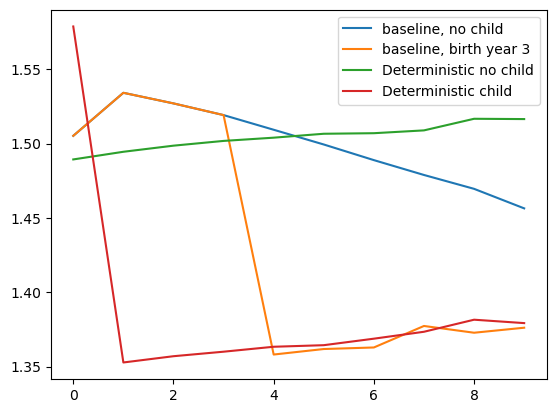

In [112]:
I = model.sim.n[:,-1] == 0
birthyear = np.argmax(np.diff(model.sim.n), axis=1)

year = 3

I_lo = model0.sim.n[:,-1] == 0
birthyear_lo = np.argmax(np.diff(model0.sim.n), axis=1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.h[I].mean(axis=0), label='baseline, no child')
ax.plot(model.sim.h[birthyear == year].mean(axis=0), label=f'baseline, birth year {year}')

ax.plot(model0.sim.h[I_lo].mean(axis=0), label='Deterministic no child')
ax.plot(model1.sim.h[birthyear == 1].mean(axis=0), label=f'Deterministic child')

ax.legend()